In [1]:
import sys
from Bio import SeqIO
from collections import defaultdict
from pyopenms import *
from matplotlib import pyplot as plt
import pandas as pd

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


In [2]:
input_fasta = '/Users/plutzer/Box/CellBio-MajorLab/Users/Rotation Students/Isaac/Digestion Code/Human_sp_2019-08-27.fasta'

In [3]:
# Code from Dennis
dig = ProteaseDigestion()
dig.setMissedCleavages(1) # I would set it to 0 first because missed cleavages are rarer

pep2prots = defaultdict(set)
prot2peps = defaultdict(set)

with open(input_fasta, "r") as handle:
    for record in SeqIO.parse(input_fasta, "fasta"):
        peptides = []
        seq = AASequence.fromString(str(record.seq))
        dig.digest(seq, peptides)
        for pep in peptides:
            s = pep.toString()#.decode("utf-8")
            if "X" not in s and len(s) >= 6 and pep.getMonoWeight() <= 4600:
                pep2prots[s].add(record.id)
                prot2peps[record.id].add(s)

In [4]:
prot2peps['sp|Q6ZS62|COLC1_HUMAN']

{'DLFVPTSSSLYGCFCVGLVSGMAISVLLLASDFR',
 'DLFVPTSSSLYGCFCVGLVSGMAISVLLLASDFRK',
 'DSKDLFVPTSSSLYGCFCVGLVSGMAISVLLLASDFR',
 'EASLWFVAQH',
 'GELLGSQGVCK',
 'GELLGSQGVCKDSK',
 'KLDFSRPEPCFEK',
 'LDFSRPEPCFEK',
 'LDFSRPEPCFEKEASLWFVAQH',
 'MESCSVAQAGVLTSPFMWR',
 'WTGMAGALSALDNTIEDDADDQLPCGEGRPGWVR'}

In [5]:
# Establish a keys list and initialize a matrix for jaccard coefficients
keys = list(prot2peps.keys())
coeffs = np.zeros((len(keys),len(keys)))

In [6]:
similar_pairs1 = []
similar_pairs2 = []
similar_coeffs = []
for index1 in range(len(keys)):
    for index2 in range(len(keys)):
        set1 = prot2peps[keys[index1]]
        set2 = prot2peps[keys[index2]]
        jaccard = len(set1.intersection(set2))/len(set1.union(set2))
        coeffs[(index1,index2)] = jaccard
        if jaccard > 0.25:
            if index1 != index2:
                similar_pairs1.append(str(keys[index1]))
                similar_pairs2.append(str(keys[index2]))
                similar_coeffs.append(jaccard)
                #print(str(keys[index1] + ' and ' + keys[index2]))

In [7]:
similar_df = pd.DataFrame(similar_pairs1,columns=['prot1'])
similar_df['prot2'] = similar_pairs2
similar_df['index'] = similar_coeffs
similar_df.to_csv('jaccards.csv')

In [31]:
# Turn the diagonals into nans
for index in range(len(keys)):
    coeffs[(index,index)] = np.nan

In [53]:
#What is the cutoff jaccard index for the CK1Gs?
boolkeys = ['KC1G' in item for item in keys]
for index in [i for i,x in enumerate(boolkeys) if x]:
    print(keys[index])

sp|P78368|KC1G2_HUMAN
sp|Q9HCP0|KC1G1_HUMAN
sp|Q9Y6M4|KC1G3_HUMAN


In [55]:
#similarity of g1 with g2
len(prot2peps['sp|Q9HCP0|KC1G1_HUMAN'].intersection(prot2peps['sp|P78368|KC1G2_HUMAN']))/len(prot2peps['sp|Q9HCP0|KC1G1_HUMAN'].union(prot2peps['sp|P78368|KC1G2_HUMAN']))

0.28703703703703703

In [56]:
#similarity of g1 with g3
len(prot2peps['sp|Q9HCP0|KC1G1_HUMAN'].intersection(prot2peps['sp|Q9Y6M4|KC1G3_HUMAN']))/len(prot2peps['sp|Q9HCP0|KC1G1_HUMAN'].union(prot2peps['sp|Q9Y6M4|KC1G3_HUMAN']))

0.25210084033613445

In [57]:
#similarity of g2 with g3
len(prot2peps['sp|P78368|KC1G2_HUMAN'].intersection(prot2peps['sp|Q9Y6M4|KC1G3_HUMAN']))/len(prot2peps['sp|P78368|KC1G2_HUMAN'].union(prot2peps['sp|Q9Y6M4|KC1G3_HUMAN']))

0.2773109243697479

In [58]:
## So ill say that around 0.25 jaccard index is where things look like the CK1Gs

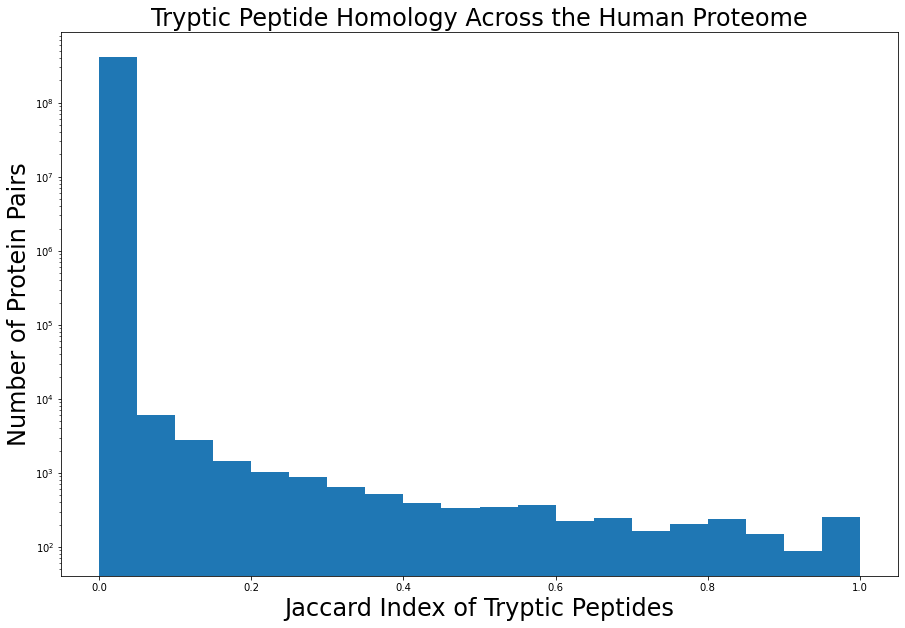

In [109]:
#Make a histogram of the coeffs table:
ax, fig = plt.subplots(figsize = (15,10))
plt.hist(coeffs.flatten(),bins = 20)
plt.yscale('log')
plt.title('Tryptic Peptide Homology Across the Human Proteome',size=24)
plt.xlabel('Jaccard Index of Tryptic Peptides',size=24)
plt.ylabel('Number of Protein Pairs',size=24)
plt.savefig('figures/hist1.png',dpi=256)

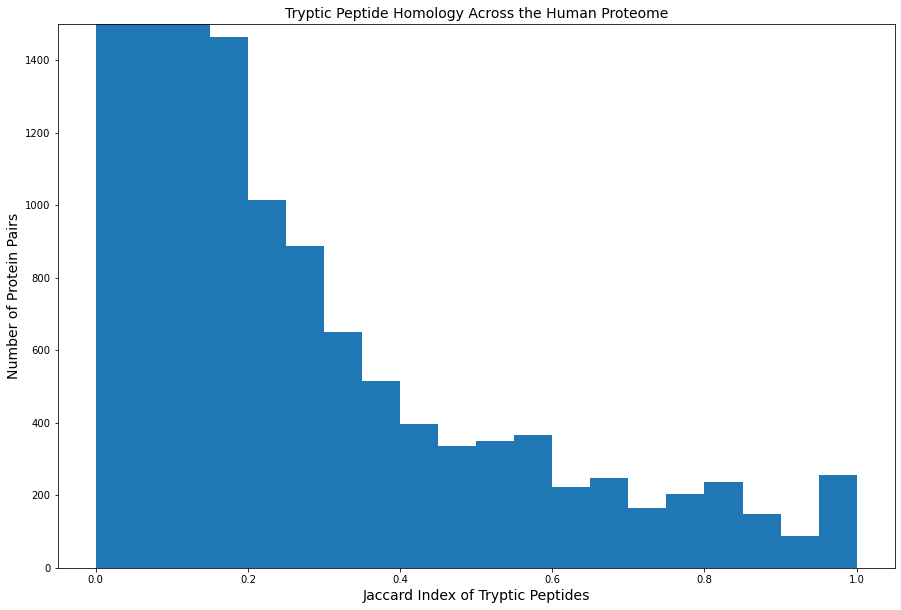

In [105]:
ax, fig = plt.subplots(figsize = (15,10))
plt.hist(coeffs.flatten(),bins=20)
plt.ylim((0,1500))
plt.title('Tryptic Peptide Homology Across the Human Proteome',size=14)
plt.xlabel('Jaccard Index of Tryptic Peptides',size=14)
plt.ylabel('Number of Protein Pairs',size=14)
plt.savefig('figures/hist2.png',dpi=256)

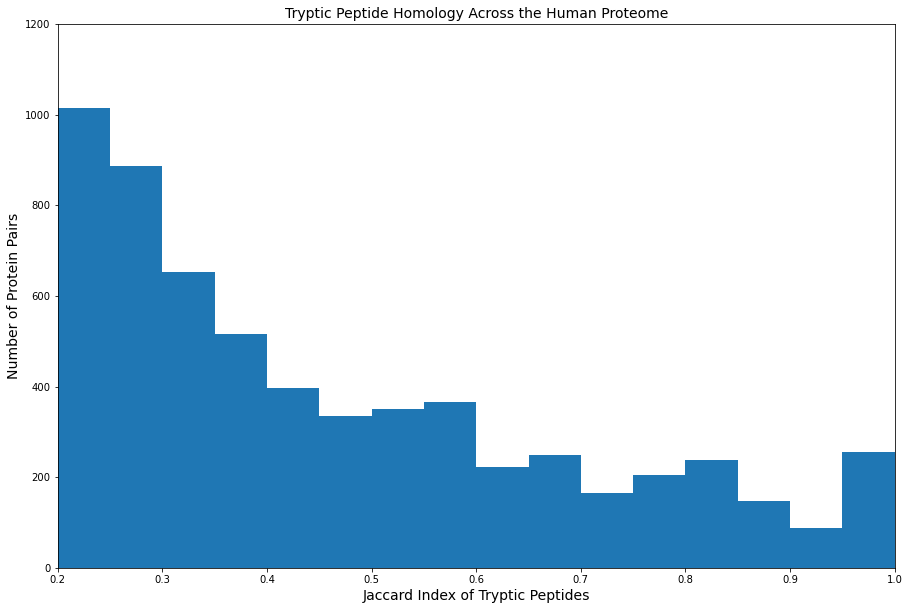

In [106]:
ax, fig = plt.subplots(figsize = (15,10))
plt.hist(coeffs.flatten(),bins=20)
plt.xlim((0.20,1))
plt.ylim((0,1200))
plt.title('Tryptic Peptide Homology Across the Human Proteome',size=14)
plt.xlabel('Jaccard Index of Tryptic Peptides',size=14)
plt.ylabel('Number of Protein Pairs',size=14)
plt.savefig('figures/hist3.png',dpi=256)

In [79]:
import seaborn as sb

In [108]:
sb.histplot(coeffs.flatten(),bins=20,palette='viridis',log_scale=True)

KeyboardInterrupt: 

In [97]:
coeffs_df = pd.DataFrame(coeffs.flatten())

In [98]:
coeffs_df = coeffs_df.rename(columns = {0:'jaccard'})

In [99]:
len(coeffs_df[coeffs_df['jaccard'] > 0.25])/len(coeffs_df)

1.1949550220372308e-05

In [103]:
coeffs_df[coeffs_df['jaccard'] > 0.27]

,jaccard
288359,0.472973
301585,0.507042
305018,0.862069
1263212,0.450000
1486043,0.638298
...,...
415728598,0.800000
415729186,0.500000
415729322,0.636364
415812783,0.333333
